<a href="https://colab.research.google.com/github/luizaaca/transfer-learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This tutorial is based on https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb.Here we will use the _transfer learning_ technique create an accurate image classifier from a relatively small number of training samples. Generally speaking, _transfer learning_ refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of 1000 images belonging to 2 classes (cats and dogs), and train an image classifier with around 80% accuracy on it.


In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset present in the https://github.com/cunhamaicon/catsxdogs/tree/master/training_set repository, which is about using transfer learning.


In [2]:
!echo "Downloading 101_Object_Categories for image notebooks"
# Baixe o repositório inteiro como um arquivo ZIP
!curl -L -o repo.zip https://github.com/cunhamaicon/catsxdogs/archive/refs/heads/master.zip

# Extraia apenas a pasta necessária
!unzip repo.zip "catsxdogs-master/training_set/*" -d .

# Crie a pasta destino se não existir
!mkdir -p training_set

# Mova os arquivos da pasta extraída para o diretório desejado
!mv catsxdogs-master/training_set/* training_set/

# Remova os diretórios desnecessários
!rm -rf catsxdogs-master repo.zip

!ls


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: ./catsxdogs-master/training_set/cats/cat.3701.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3702.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3703.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3704.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3705.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3706.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3707.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3708.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3709.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.371.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3710.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3711.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3712.jpg  
  inflating: ./catsxdogs-master/training_set/cats/cat.3713.jpg  
  inflating: ./catsxdogs-master/

In [3]:
root = 'training_set'
#exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
#categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['training_set/dogs', 'training_set/cats']


This function is useful for pre-processing the data into an image and input vector.

In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)
print(len(data))

8000


Randomize the data order and limit the quantity of images to 1000 in order to avoid memory limitations.

In [6]:
random.shuffle(data)
data = data[:1000]

create training / validation / test split (70%, 15%, 15%)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(150, 2)


Let's get a summary of what we have.

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1000 images from 2 categories
train / validation / test split: 700, 150, 150
training data shape:  (700, 224, 224, 3)
training labels shape:  (700, 2)


If everything worked properly, you should have loaded a bunch of images, and split them into three sets: `train`, `val`, and `test`. The shape of the training data should be (`n`, 224, 224, 3) where `n` is the size of your training set, and the labels should be (`n`, `c`) where `c` is the number of classes.

Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.

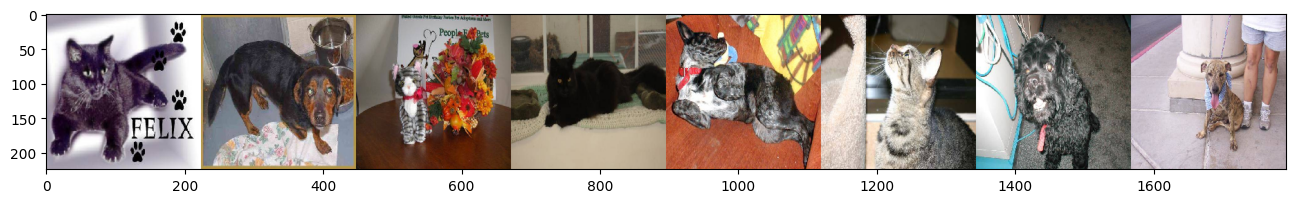

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5051 - loss: 0.7250 - val_accuracy: 0.4533 - val_loss: 0.6962
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5284 - loss: 0.6875 - val_accuracy: 0.4467 - val_loss: 0.6971
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5527 - loss: 0.6783 - val_accuracy: 0.5467 - val_loss: 0.6935
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5944 - loss: 0.6675 - val_accuracy: 0.5333 - val_loss: 0.6967
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6168 - loss: 0.6501 - val_accuracy: 0.5267 - val_loss: 0.6897
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6076 - loss: 0.6381 - val_accuracy: 0.5867 - val_loss: 0.6710
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6871 - loss: 0.6208 - val_accuracy: 0.5667 - val_loss: 0.6785
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6780 - loss: 0.6023 - val_accuracy: 0.5933 - val_loss: 0

Let's plot the validation loss and validation accuracy over time.

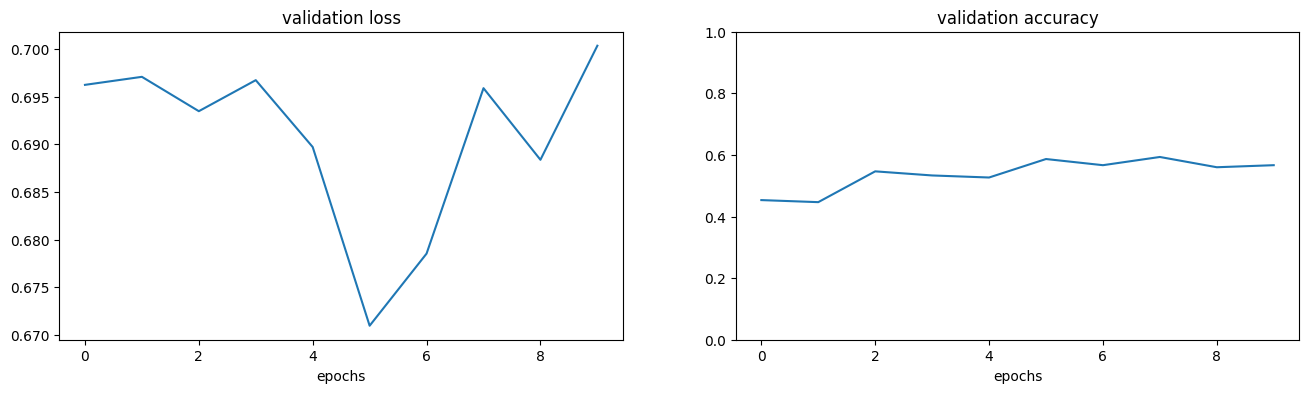

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that the validation loss begins to actually rise after around 5 epochs, even though validation accuracy remains roughly between 50% and 60%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6622787714004517
Test accuracy: 0.6399999856948853


Finally, we see that we have achieved a (top-1) accuracy of around 64%.

## Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [17]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 2 neurons in the case of the _cats and dogs_ dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [18]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [19]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 2-neuron softmax.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [20]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.5040 - loss: 1.1098 - val_accuracy: 0.6867 - val_loss: 0.6261
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.5960 - loss: 0.7349 - val_accuracy: 0.7400 - val_loss: 0.5725
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.6099 - loss: 0.6333 - val_accuracy: 0.5333 - val_loss: 0.6616
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 731ms/step - accuracy: 0.6770 - loss: 0.5461 - val_accuracy: 0.7533 - val_loss: 0.4953
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.7382 - loss: 0.5266 - val_accuracy: 0.7267 - val_loss: 0.5076
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 733ms/step - accuracy: 0.8108 - loss: 0.4405 - val_accuracy: 0.8333 - val_loss: 0.4112
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 743ms/step - accuracy: 0.8240 - loss: 0.4185 - val_accuracy: 0.7933 - val_loss: 0.4261
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step - accuracy: 0.8515 - loss: 0.3953 - val_accuracy: 0.8467 - val_loss: 0

Our validation accuracy hovers near to 83% towards the end.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in orange.

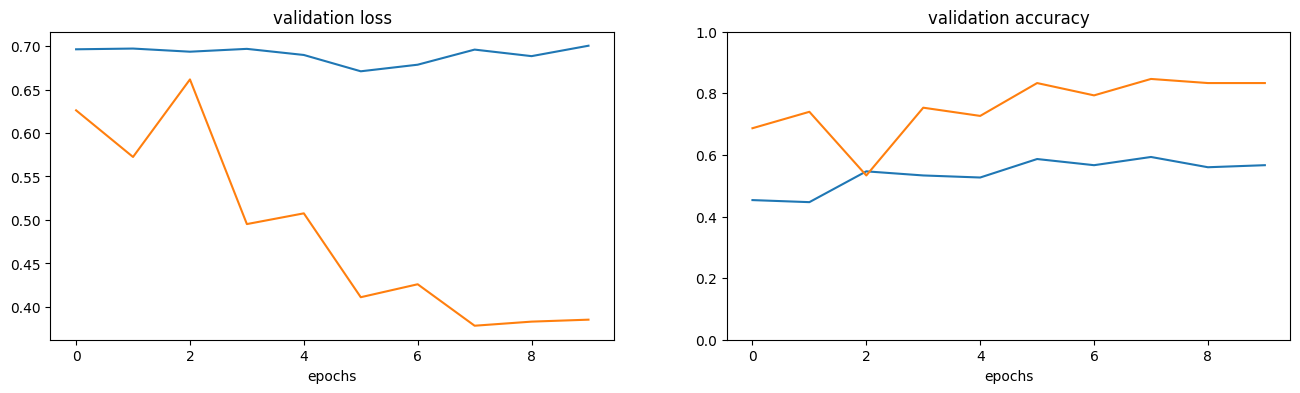

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that whereas the original model began overfitting around epoch 5, the new model continued to slowly decrease its loss over time, although it started to increase slightly after 7 epochs.

It's possibly we could have improved the original model with better regularization or more dropout.

Again, we do a final validation on the test set.

In [22]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3715974986553192
Test accuracy: 0.8933333158493042


To predict a new image, simply run the following code to get the probabilities for each class.

In [24]:
img, x = get_image('training_set/dogs/dog.1899.jpg')
probabilities = model_new.predict([x])
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[9.9999988e-01 1.4526665e-07]]
